In [1]:
import numpy as np
from easyvec import Vec3
from interpolation import Interp1d, Interp2d

In [ ]:
opts = {
    'd': ,
    'L': ,
    'm_0': ,
    't_marsh': ,
    'w_marsh': ,
    'P_marsh': 
}

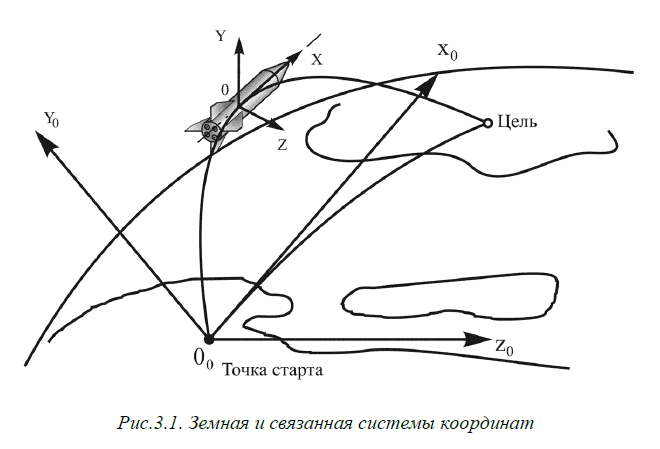

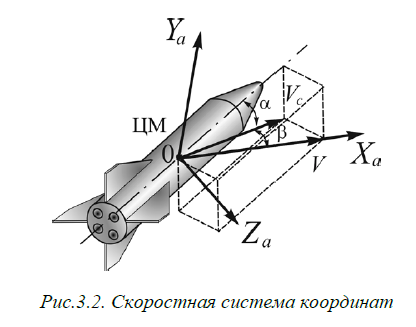

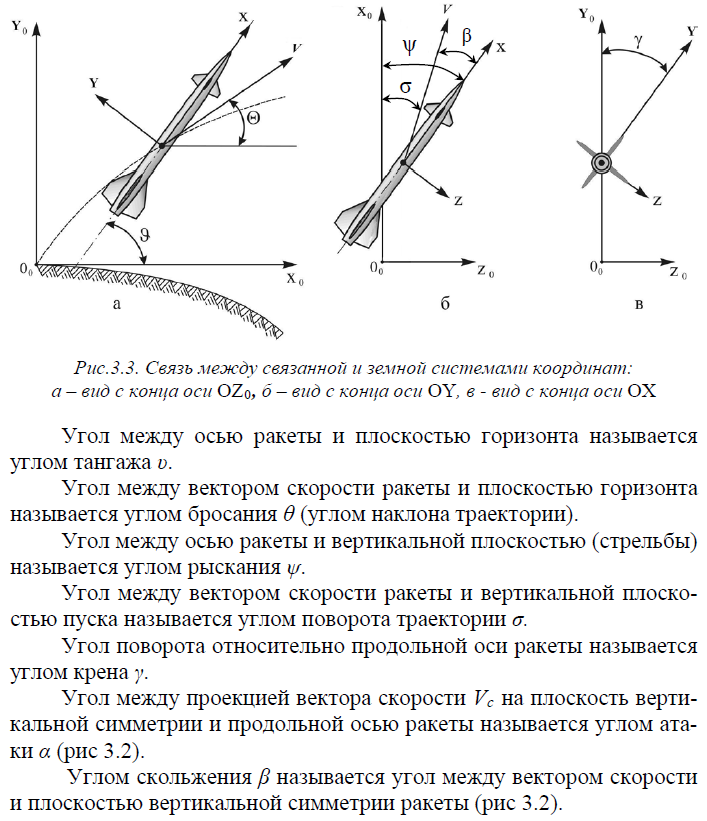

In [ ]:
class Missile3D(object):
    
    @classmethod
    def get_missile(cls, opts):
        """
        Классовый метод создания ракеты со всеми необходимыми аэродинамическими, массо- и тяговременными характеристиками
        
        Arguments
        ---------
        opts : dict 
               словарь с параметрами ракеты
               
        Returns
        -------
        cls
        экземпляр класса Missile3D
        """
        @np.vectorize
        def get_m(t):
            if t < t_marsh:
                return m_0 - G_marsh * t
            else:
                return m_0 - w_marsh
            
        @np.vectorize
        def get_P(t):
            if t < t_marsh:
                return P_marsh
            else:
                return 0
        
        @np.vectorize
        def get_J(t):
            # TODO: функция должна возвращать список или нп массив с 3 числами Ix, Iy, Iz
            if t < t_marsh:
                return (m_0 - G_marsh * t) * L**2
            else:
                return (m_0 - w_marsh) * L**2
        
        g       = opts.get('g', 9.80665)
        d       = opts['d']
        L       = opts['L']
        m_0     = opts['m_0']
        t_marsh = opts['t_marsh']
        w_marsh = opts['w_marsh']
        P_marsh = opts['P_marsh']
        
        G_marsh = w_marsh / t_marsh
        
        ts    = np.linspace(0, t_marsh, 100)
        m_itr = Interp1d(ts, get_m(ts))
        J_itr = get_J(ts)
        P_itr = Interp1d(ts, get_P(ts))
        atm_itr = table_atm
        
        df1 = pd.read_csv('data_constants/cya_from_mach.csv', sep = ";")
        df2 = pd.read_csv('data_constants/cx_from_mach_and_alpha.csv', sep = ";", index_col=0)
        arr_alpha = np.array(df2.index)
        arr_mach = df1['Mach']
        arr_cya = df1['Cya']
        arr_cx = df2.to_numpy()

        Cx_itr  = Interp2d(arr_alpha, arr_mach, arr_cx)
        Cya_itr = Interp1d(arr_mach, arr_cya)
        
        missile = cls(g=g, d=d, P_itr=P_itr, m_itr=m_itr, Cx_itr=Cx_itr, Cya_itr=Cya_itr, atm_itr=atm_itr, J_itr=J_itr)
        return missile
    
    def __init__(self, qw=1, qx=0, qy=0, qz=0, g=9.80665, n=14, **kwargs):
        """
        Конструктор класса Missile3D
        
        Arguments
        ---------
        
        ...
        
        """
        self.g = g
        self.t = 0
        self.v = 0
        self.v_0 = 0
        self.n = n
        self.state = np.zeros(self.n)
        self.state_init = np.zeros(self.n)
        
        self.mu_omega = 1.0
        
        self.d       = kwargs['d']
        self.P_itr   = kwargs['P_itr']
        self.m_itr   = kwargs['m_itr']
        self.Cx_itr  = kwargs['Cx_itr']
        self.Cya_itr = kwargs['Cya_itr']
        self.atm_itr = kwargs['atm_itr']
        self.J_itr   = kwargs['J_itr']
        
        # Инициилизация кватерниона 
        if ("scalar" in kwargs) or ("vector" in kwargs):
            # с помощью скалярной и векторной части
            scalar = kwargs.get("scalar", 0.0)
            if scalar is None:
                scalar = 0.0
            else:
                scalar = float(scalar)
            vector = kwargs.get("vector", [])
            vector = self._validate_number_sequence(vector, 3)
            self.qw = scalar
            self.qx, self.qy, self.qz = vector
        elif ("thetta" in kwargs) or ("psi" in kwargs) or ("gamma" in kwargs):
            # с помощью самолетных углов
            thetta = np.radians(kwargs.get("thetta", 0.0))
            psi = np.radians(kwargs.get("psi", 0.0))
            gamma = np.radians(kwargs.get("gamma", 0.0))
            self.qw = np.cos(thetta/2) * np.cos(psi/2) * np.cos(gamma/2) + np.sin(thetta/2) * np.sin(psi/2) * np.sin(gamma/2)
            self.qx = np.cos(thetta/2) * np.cos(psi/2) * np.sin(gamma/2) - np.sin(thetta/2) * np.sin(psi/2) * np.cos(gamma/2)
            self.qy = np.cos(thetta/2) * np.sin(psi/2) * np.cos(gamma/2) + np.sin(thetta/2) * np.cos(psi/2) * np.sin(gamma/2)
            self.qz = np.sin(thetta/2) * np.cos(psi/2) * np.cos(gamma/2) - np.cos(thetta/2) * np.sin(psi/2) * np.sin(gamma/2)
        elif "array" in kwargs:
            self.qw, self.qx, self.qy, self.qz = self._validate_number_sequence(kwargs["array"], 4)
        else:
            # по умолчанию
            self.qw = qw
            self.qx = qx
            self.qy = qy
            self.qz = qz            
    
    @property
    def quaternion(self):
        """
        Кватернион результируюшего текущего поворота (кватернион как четырехмерный вектор)
        
        Returns
        -------
        quaternion : np.ndarray
                     q = [qw, qx, qy, qz] 
                         [ 0,  1,  2,  3]
        """
        return np.array([self.qw, self.qx, self.qy, self.qz])
    
    @property
    def pos(self, to_numpy=False):
        """
        Пространственный вектор положения ракеты в ГСК
        
        Returns
        -------
        np.ndarray / cls Vec3
        [x, y, z] 
        [0, 1, 2]
        """
        if to_numpy == False:
            return Vec3(self.state[0], self.state[1], self.state[2])
        else:
            return np.array([self.state[0], self.state[1], self.state[2]])
    
    @property
    def axis(self):
        # TODO ось ракеты вернуть
        pass
    
    @property
    def vel(self, to_numpy=False):
        """
        Пространственный вектор скорости ракеты
        
        Returns
        -------
        np.ndarray / cls Vec3
        [vx, vy, vz] 
        [0,   1,  2]
        """
        if to_numpy == False:
            return Vec3(self.state[3], self.state[4], self.state[5])
        else:
            return np.array([self.state[3], self.state[4], self.state[5]])

    @property
    def w(self, to_numpy=False):
        """
        Пространственный вектор углового вращения ракеты в ССК
        
        Returns
        -------
        np.ndarray / cls Vec3
        [wx, wy, wz] 
        [0,   1,  2]
        """
        if to_numpy == False:
            return Vec3(self.state[6], self.state[7], self.state[8])
        else:
            return np.array([self.state[6], self.state[7], self.state[8]])
    
    def f_system(self, t, y):
        """
        Функция, записывающая правую часть системы ОДУ динамики материального тела в пространстве.
        
        Arguments
        ---------
        t : float
            Время в секундах
        y : np.ndarray / list
            Вектор состояния системы 
            [0, 1, 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]
            [x, y, z, vx, vy, vz, wx, wy, wz, qw, qx, qy, qz,  t]     
            
        Returns
        -------
        dy : np.ndarray / list
             Вектор состояния после дифференцирования системы dy/dt
             [0,   1,  2,  3,  4,  5,    6,    7,    8,   9,  10,  11,  12, 13]
             [vx, vy, vz, ax, ay, az, epsx, epsy, epsz, dqw, dqx, dqy, dqz,  1]
        """
        x, y, z, vx, vy, vz, qw, qx, qy, qz, wx, wy, w3, t = y
        
        rho = self.atm_itr(y[1], 3)

        v = np.sqrt(y[3]**2 + y[4]**2 + y[5]**2)
        
        if v < 1e-5:
            F_Cx = 0
            F_Cx_x = 0
            F_Cx_y = 0
            F_Cx_z = 0
        else:
#             F_Cx = self.Cx_itr() * rho * v**2 / 2
            F_Cx_x = - F_Cx * (vx / v)
            F_Cx_y = - F_Cx * (vy / v)
            F_Cx_z = - F_Cx * (vz / v)
        
        
        J_x, J_y, J_z = self.J 
        X = F_Cx_x + # TODO
        Y = F_Cx_y + # TODO
        Z = F_Cx_z + # TODO
        
        dy = np.zeros(self.n)

        dy[0] = vx # dx/dt = v_x
        dy[1] = vy # dy/dt = v_y
        dy[2] = vz # dz/dt = v_z
        dy[3] = Fx / self.m_itr(t) - y[5] * y[7] + y[4] * y[8] # dv_x/dt = a_x
        dy[4] = Fy / self.m_itr(t) - y[3] * y[8] + y[5] * y[6] # dv_y/dt = a_y
        dy[5] = Fz / self.m_itr(t) - y[4] * y[6] + y[3] * y[7] - self.g # dv_y/dt = a_y
        dy[6] = (M_x + (J_y - J_z) * y[7] * y[8]) / J_x # domega_x/dt = eps_x
        dy[7] = (M_y + (J_z - J_x) * y[8] * y[6]) / J_y # domega_y/dt = eps_y
        dy[8] = (M_z + (J_x - J_y) * y[6] * y[7]) / J_z # domega_z/dt = eps_z
        dy[9] = -1/2 * (qx * wx + qy * wy + qz * wz) # dq_w/dt
        dy[10] = 1/2 * (qw * wx - qz * wy + qy * wz) # dq_x/dt 
        dy[11] = 1/2 * (qw * wy - qx * wz + qz * wx) # dq_y/dt
        dy[12] = 1/2 * (qw * wz - qy * wx + qx * wy) # dq_z/dt
        dy[13] = 1 # dt
        
        return dy
       
    def step(self, tau=0.1, n=10):
        """
        Метод моделирования динамики ракеты за шаг по времени tau
        На протяжении tau управляющее воздействие на ракету постоянно (action)
        Шаг интегирования dt определяется из числа разбиения n временного шага tau
        Функция меняет внутреннее состояние ракеты state на момент окончания шага
        
        Arguments
        ---------
        action : int
                 управляющее воздействие на протяжении шага
        tau : float 
              длина шага по времени (не путать с шагом интегрирования)
        n : int
            число шагов разбиений интервала времени tau
            
        Returns
        -------
        None
        """
        t = self.state[-1]  
        dt = tau / n
        for i in range(n):
            k1 = self.f_system(t, self.state)
            k2 = self.f_system(t + 0.5 * dt, self._validate_y(self.state + 0.5 * dt * k1))
            k3 = self.f_system(t + 0.5 * dt, self._validate_y(self.state + 0.5 * dt * k2))
            k4 = self.f_system(t + dt,       self._validate_y(self.state + dt * k3))
            y = self._validate_y(self.state + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4))
            t += dt
            self.t = t
            self.state = y
            self.state[-1] = t
        
    def get_angle(self):
        qw, qx, qy, qz = self.quaternion
        thetta = np.arctan(2*(qx*qy+qw*qz)/(2*(qw**2+qx**2)-1))
        psi = np.arcsin(2*(qw*qy-qx*qz))
        gamma = np.arctan(2*(qy*qz+qw*qx)/(2*(qw**2+qz**2)-1))
        return np.array([thetta, psi, gamma])
    
    def get_standart_parameters_of_missile(self):
        """
        Метод, возвращающий начальное состояние ракеты
        
        Returns
        -------
        np.ndarray [x, y, z, vx, vy, vz, wx, wy, wz, qw, qx, qy, qz, t]
        """
#         return np.array([0, 0, 0, self.v_0, ..., 0, 0, 0, 1, 0, 0, 0, 0])   
        pass
        
    def set_initial_condition(self, parameters_of_missile=None):
        """
        Метод, задающий начальные параметры (положение, линейную скорость, угловую скорость, кватернион, время)
        
        Arguments
        ---------
        parameters_of_missile : list / np.ndarray
                                [x, y, z, vx, vy, vz, wx, wy, wz, qw, qx, qy, qz, t]
        
        Returns
        -------
        None
        """
        if parameters_of_missile is None:
            parameters_of_missile = self.get_standart_parameters_of_missile()
        self.state = np.array(parameters_of_missile)
        self.state_init = np.array(parameters_of_missile)
    
    def to_dict(self):
        return {
            't': self.t,
            'pos': Vec3(self.state[0], self.state[1], self.state[2]),
            'vel': Vec3(self.state[3], self.state[4], self.state[5]),
            'q': self.quaternion,
            'w': self.w
        }
    
    def to_numpy(self):
        return np.array(self.state)
    
    def from_dict(self, state_dict):
        # TODO
        pass
    
    def from_numpy(self, state_numpy):
        # TODO
        pass
    
    def get_B(delta_t, A, velA):
        return A.add_vec(velA.mul_num(delta_t / 3))

    def get_C(delta_t, D, velD): 
        return D.sub_vec(velD.mul_num(delta_t / 3))
    
    def get_traject(self, delta_t, pos_trg, vel_trg, n_points=100):
        taus = np.linspace(0, 1, n_points)
        A = Vec3(self.state[0], self.state[1], self.state[2])
        velA = Vec3(self.state[3], self.state[4], self.state[5])
        D = Vec3(pos_trg[0], pos_trg[1], pos_trg[2])
        velD = Vec3(vel_trg[0], vel_trg[1], vel_trg[2])
        B = self.get_B(delta_t, A, velA)
        C = self.get_C(delta_t, D, velD)
        return np.array([
            (1-tau)**3 * A + 3*tau*(1-tau)**2 * B + 3*tau*tau*(1-tau)*C + tau**3 * D
            for tau in taus
        ])
    
    def get_traject_vels(self, delta_t, pos_trg, vel_trg, n_points=100):
        taus = np.linspace(0, 1, n_points)
        A = Vec3(self.state[0], self.state[1], self.state[2])
        velA = Vec3(self.state[3], self.state[4], self.state[5])
        D = Vec3(pos_trg[0], pos_trg[1], pos_trg[2])
        velD = Vec3(vel_trg[0], vel_trg[1], vel_trg[2])
        B = self.get_B(delta_t, A, velA)
        C = self.get_C(delta_t, D, velD)
        return np.array([
            (3*(1-tau)**2*(B-A) + 6*tau*(1-tau)*(C-B) + 3*tau**2*(D-C)) / delta_t
            for tau in taus
        ])
    
    def get_traject_acc(self, delta_t, pos_trg, vel_trg, n_points=100):
        taus = np.linspace(0, 1, n_points)
        A = Vec3(self.state[0], self.state[1], self.state[2])
        velA = Vec3(self.state[3], self.state[4], self.state[5])
        D = Vec3(pos_trg[0], pos_trg[1], pos_trg[2])
        velD = Vec3(vel_trg[0], vel_trg[1], vel_trg[2])
        B = self.get_B(delta_t, A, velA)
        C = self.get_C(delta_t, D, velD)
        return np.array([
            6 * ((tau-1)*(B-A) + (1-2*tau)*(C-B) + tau*(D-C)) / delta_t**2
            for tau in taus
        ])
    
    def _validate_number_sequence(self, seq, n):
        if seq is None:
            return np.zeros(n)
        if len(seq) == 0:
            return np.zeros(n)            
        elif len(seq) == n:
            try:
                l = [float(elem) for elem in seq]
            except ValueError:
                raise ValueError("Один или несколько элементов в <{!r}> не действительное(-ые) число(-а)".format(seq))
            else:
                return np.array(l)    
        else:
            raise ValueError("Неожиданное число элементов. Получено: {}, Ожидалось: {}.".format(len(seq), n))      
    
    def _validate_y(self, y):
    # TODO: проверка углов
    # return y
        pass